In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, r2_score
from prophet import Prophet

project_root = os.path.join(os.getcwd(), "..")
file_path = os.path.join(project_root, "data", "cleaned_us_renewable_energy_no_2024.csv")

df_clean = pd.read_csv(file_path)

ts_df = df_clean.groupby(['Date'])['Total_Renewable'].sum().reset_index()
ts_df.columns = ['ds', 'y']

In [17]:
train = ts_df[ts_df['ds'] < '2015-01-01'].copy()
val = ts_df[(ts_df['ds'] >= '2015-01-01') & (ts_df['ds'] < '2020-01-01')].copy()
test = ts_df[ts_df['ds'] >= '2020-01-01'].copy()

In [18]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=False)
model.fit(train)

future = model.make_future_dataframe(periods=len(val) + len(test), freq='MS')
forecast = model.predict(future)

forecast['ds'] = pd.to_datetime(forecast['ds'])

val_mask = (forecast['ds'] >= '2015-01-01') & (forecast['ds'] < '2020-01-01')
val_pred = forecast[val_mask]['yhat'].values
val_y = val['y'].values

print("Validation actual data length:", len(val_y))
print("Estimated data length:", len(val_pred))

mae = mean_absolute_error(val_y, val_pred)
print(f"Validation MAE: {mae:.2f}")

16:58:08 - cmdstanpy - INFO - Chain [1] start processing
16:58:08 - cmdstanpy - INFO - Chain [1] done processing


Validation actual data length: 60
Estimated data length: 60
Validation MAE: 29.13


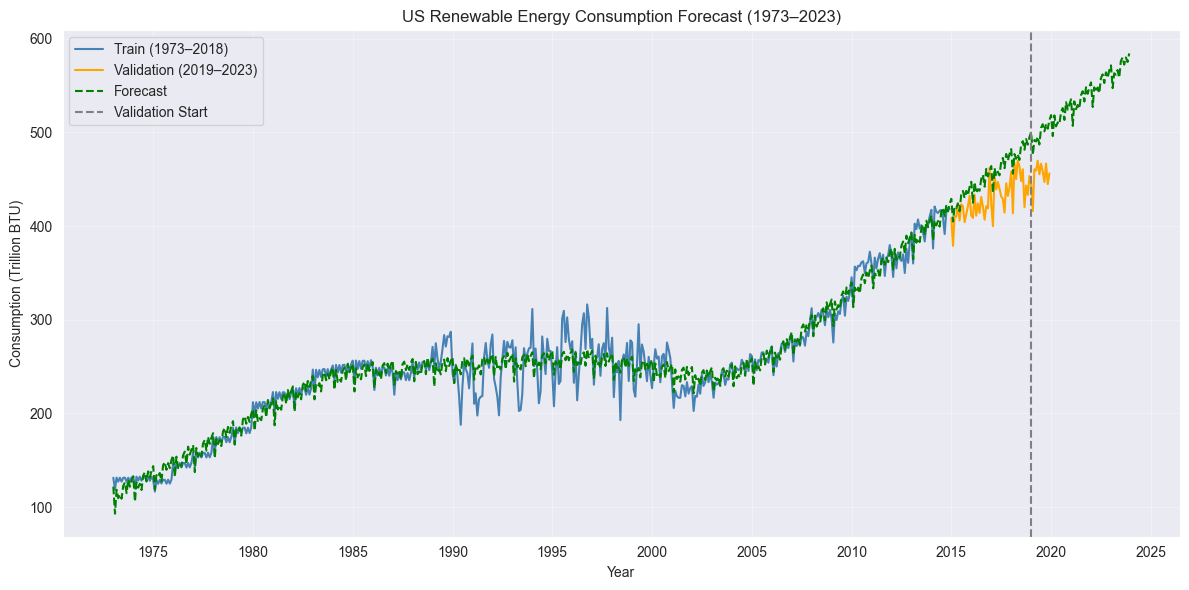

In [19]:
train['ds'] = pd.to_datetime(train['ds']).dt.tz_localize(None)
val['ds'] = pd.to_datetime(val['ds']).dt.tz_localize(None)
forecast['ds'] = pd.to_datetime(forecast['ds']).dt.tz_localize(None)

plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Train (1973–2018)', color='steelblue')
plt.plot(val['ds'], val['y'], label='Validation (2019–2023)', color='orange')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='green', linestyle='--')

plt.axvline(x=pd.to_datetime('2019-01-01'), color='gray', linestyle='--', label='Validation Start')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('US Renewable Energy Consumption Forecast (1973–2023)')
plt.xlabel('Year')
plt.ylabel('Consumption (Trillion BTU)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [25]:
ts_df = df_clean[df_clean['Year'] <= 2023].groupby(['Date'])['Total_Renewable'].sum().reset_index()
ts_df.columns = ['ds', 'y']
ts_df['ds'] = pd.to_datetime(ts_df['ds'])

train = ts_df[ts_df['ds'] < '2019-01-01'].copy()

val = ts_df[(ts_df['ds'] >= '2019-01-01') & (ts_df['ds'] <= '2023-12-01')].copy()

In [39]:
from prophet import Prophet

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False)

model_prophet.fit(train[['ds', 'y']])

future = model_prophet.make_future_dataframe(periods=len(val), freq='MS')
forecast_prophet = model_prophet.predict(future)

prophet_pred = forecast_prophet[forecast_prophet['ds'].isin(val['ds'])]['yhat'].values

18:55:51 - cmdstanpy - INFO - Chain [1] start processing
18:55:51 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hw = ExponentialSmoothing(
    train['y'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
)

fitted_hw = model_hw.fit()

hw_pred = fitted_hw.forecast(steps=len(val))

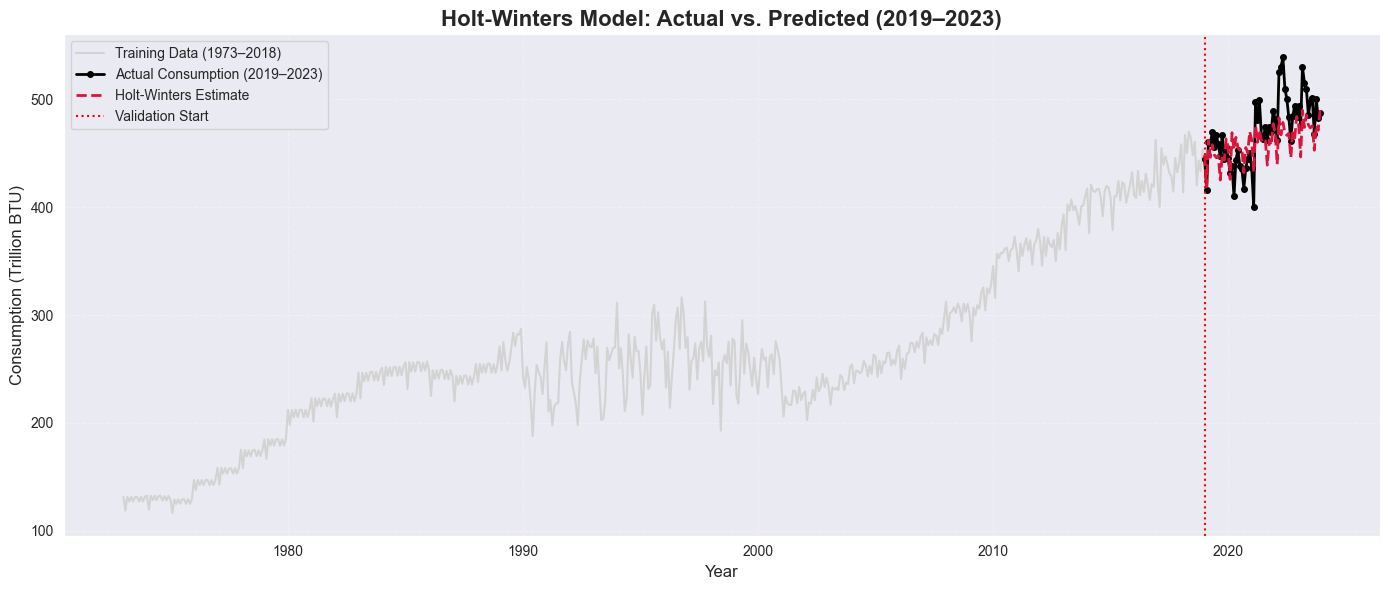

In [45]:
import matplotlib.pyplot as plt

val_dates = val['ds'].values

plt.figure(figsize=(14, 6))
plt.grid(True, alpha=0.3, linestyle='--')

plt.plot(train['ds'], train['y'],
         color='lightgray', linewidth=1.5, label='Training Data (1973–2018)')

plt.plot(val['ds'], val['y'],
         color='black', linewidth=2, marker='o', markersize=4,
         label='Actual Consumption (2019–2023)')

plt.plot(val_dates, hw_pred,
         color='crimson', linestyle='--', linewidth=2,
         label='Holt-Winters Estimate')

plt.axvline(x=val['ds'].min(), color='red', linestyle=':', linewidth=1.5,
            label='Validation Start')

plt.title('Holt-Winters Model: Actual vs. Predicted (2019–2023)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Consumption (Trillion BTU)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

Prophet MAE: 34.48
Holt-Winters MAE: 19.22


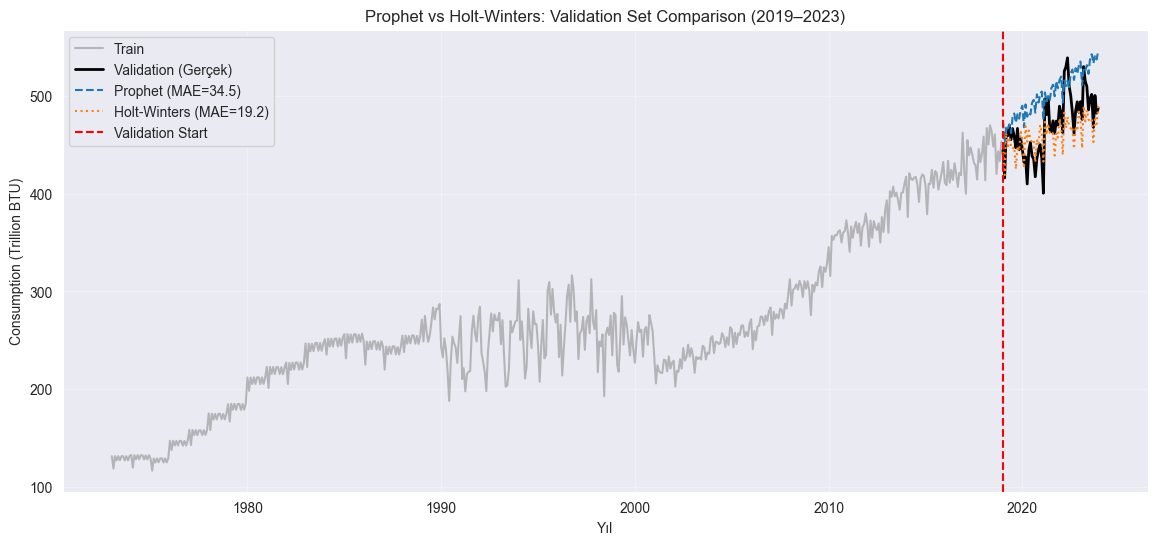

In [44]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

mae_prophet = mean_absolute_error(val['y'], prophet_pred)
mae_hw = mean_absolute_error(val['y'], hw_pred)

print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Holt-Winters MAE: {mae_hw:.2f}")

plt.figure(figsize=(14, 6))
plt.plot(train['ds'], train['y'], label='Train', color='gray', alpha=0.5)
plt.plot(val['ds'], val['y'], label='Validation (Gerçek)', color='black', linewidth=2)
plt.plot(val['ds'], prophet_pred, label=f'Prophet (MAE={mae_prophet:.1f})', linestyle='--')
plt.plot(val['ds'], hw_pred, label=f'Holt-Winters (MAE={mae_hw:.1f})', linestyle=':')

plt.axvline(x=pd.to_datetime('2019-01-01'), color='red', linestyle='--', label='Validation Start')
plt.title('Prophet vs Holt-Winters: Validation Set Comparison (2019–2023)')
plt.xlabel('Yıl')
plt.ylabel('Consumption (Trillion BTU)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

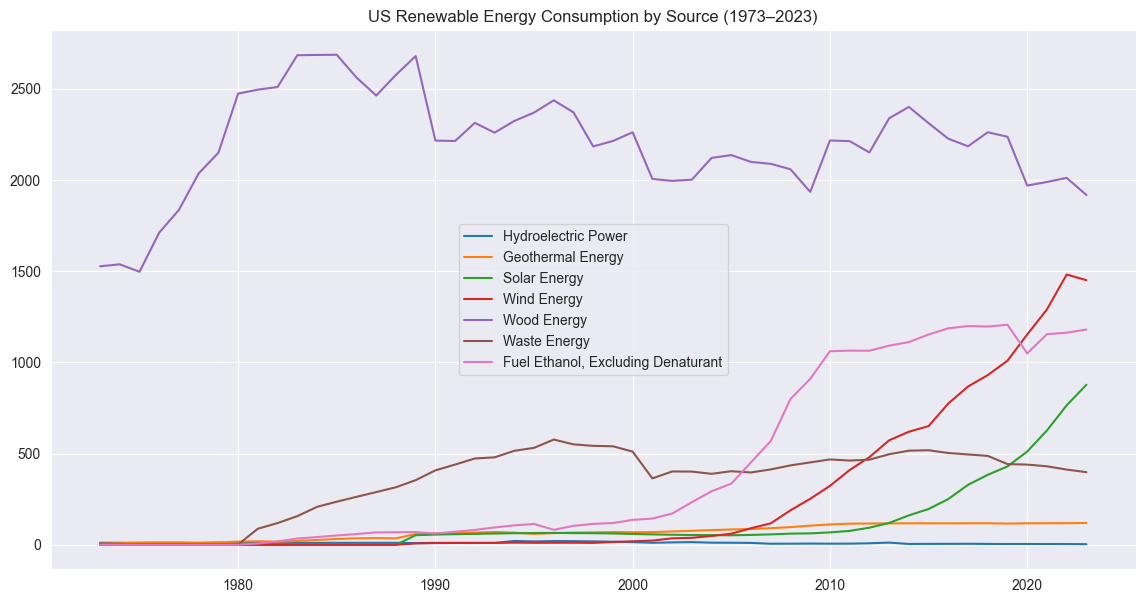

In [20]:
renewable_cols = [
    'Hydroelectric Power',
    'Geothermal Energy',
    'Solar Energy',
    'Wind Energy',
    'Wood Energy',
    'Waste Energy',
    'Fuel Ethanol, Excluding Denaturant'
]

yearly_total = df_clean.groupby('Year')[renewable_cols].sum().reset_index()

plt.figure(figsize=(14,7))
for col in renewable_cols:
    plt.plot(yearly_total['Year'], yearly_total[col], label=col)
plt.legend()
plt.title('US Renewable Energy Consumption by Source (1973–2023)')
plt.show()

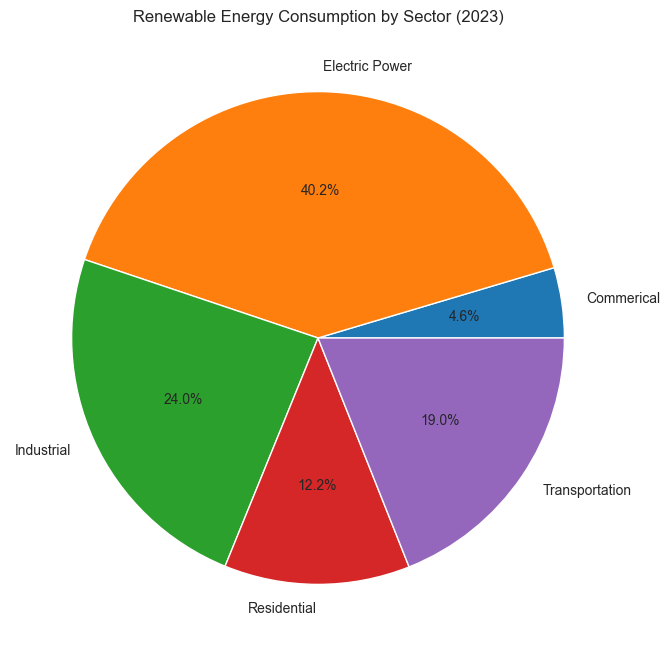

In [11]:
sector_2024 = df_clean[df_clean['Year'] == 2023].groupby('Sector')['Total_Renewable'].sum()
sector_2024.plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('Renewable Energy Consumption by Sector (2023)')
plt.ylabel('')
plt.show()